## DeepWalk

Implementation based on the paper: <i>DeepWalk: Online Learning of Social Representations</i>.

In [1]:
import numpy as np
import tensorflow as tf
import spektral
import random
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten,Concatenate,Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

### CORA Dataset

2708 scientific publications, each represented by 1433 binary-word-count features, with 7 unique classes of papers.

In [2]:
graph = spektral.datasets.citation.Citation('cora',random_split=False,normalize_x=False)
graph = graph[0]
graph

Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)

In [3]:
# a: adjacency matrix (edge weights are 1 or 0, undirected graph), x: node features, y: labels
a,x,y = graph['a'],graph['x'],graph['y']
y = np.argmax(y,axis=-1)
a = np.asarray(a.todense())
print(a.shape,x.shape,y.shape)
print(a.dtype,x.dtype,y.dtype)

(2708, 2708) (2708, 1433) (2708,)
float32 float32 int64


### DeepWalk Embeddings

In [4]:
# simulating the random walks (using uniform distribution over neighbors)
target_nodes = []
context_nodes = []
k = 10 # number of times to use a vertex as the target node
t = 10 # random walk length

neighbors = [] # nested list of neighborhood-nodes(indices) for each vertex-node
for i in range(len(a)):
    neighbors.append(list(np.nonzero(a[i,:])[0]))

for v in range(len(a)): # simulations for all vertices
    for _ in range(k): # simulation using this vertex as target
        v_n = v
        for i in range(t):
            v_n = random.choice(neighbors[v_n])
            target_nodes.append(v)
            context_nodes.append(v_n)
            
target_nodes,context_nodes = shuffle(target_nodes,context_nodes,random_state=10)
target_nodes = np.array(target_nodes).astype("int32") # input to the model
print(target_nodes[:10])
print(context_nodes[:10])

[1781 1761 1814 2121  119 2540 2035  602  107  562]
[775, 2283, 1810, 2040, 379, 2242, 788, 1662, 1113, 1735]


In [5]:
# generating the negative samples for negative sampling
n_neg_samples = 5
sampled_indices = [] # includes the context index & sampled neg. indices
for c in context_nodes:
    this_sampled_indices = [c]
    this_sampled_indices += list(np.random.choice([i for i in range(len(a)) if i != c],size=n_neg_samples,replace=False))
    sampled_indices.append(this_sampled_indices)
    
sampled_indices = np.array(sampled_indices).astype("int32")
print(sampled_indices.shape)
print(sampled_indices[0])

(270800, 6)
[ 775 1767 1514 2126  551 2467]


In [6]:
def compile_model(embedding_layer,n_vertices=2708):
    """ model to train node vectors
    """
    x = Input(shape=()) # index of the target node
    x_emb = embedding_layer(x)
    out = Dense(n_vertices,use_bias=False,activation=None)(x_emb)
    
    model = Model(inputs=x,outputs=out)
    return model

In [7]:
@tf.function
def train(model,optimizer,target_nodes,sampled_indices):
    """ training iteration
    """
    with tf.GradientTape() as tape:
        logits = model(target_nodes)
        sampled_nodes = tf.gather(logits,sampled_indices,batch_dims=1)
        scaled_output = Activation('sigmoid')(sampled_nodes)
        context_node = scaled_output[:,0]
        context_node = tf.clip_by_value(context_node,clip_value_min=0.00000001,clip_value_max=1) # clipping prevents log-loss from going to inf, especially when using float32 instead of float64
        neg_nodes = tf.clip_by_value(scaled_output[:,1:],clip_value_min=0,clip_value_max=0.9999999)
        loss = tf.reduce_mean(-tf.math.log(context_node))+tf.reduce_mean(tf.reduce_sum(-tf.math.log(1-neg_nodes),axis=-1))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [8]:
embedding_layer = Embedding(input_dim=2708,output_dim=128,trainable=True,mask_zero=False)
model = compile_model(embedding_layer)

In [9]:
batch_size=100
optimizer=Adam(lr=0.005)
epochs=5

for epoch_i in range(epochs):
    losses = []
    for i in range(0,(len(target_nodes)//batch_size)*batch_size,batch_size):
        target_nodes_subset = target_nodes[i:i+batch_size]
        sampled_indices_subset = sampled_indices[i:i+batch_size]
        batch_loss = train(model,optimizer,target_nodes_subset,sampled_indices_subset)
        losses.append(float(batch_loss))

    print(str(epoch_i)+":",sum(losses)/len(losses))

0: 1.3710380643606186
1: 0.6259660825045281
2: 0.5155609108265516
3: 0.49394057517213696
4: 0.49976183086677706


### CORA Classification

In [10]:
# creating the train,test sets
indices = np.array([i for i in range(len(y))])
indices_per_class = [indices[y==i] for i in range(7)]
test_x = np.hstack([class_i[0:50] for class_i in indices_per_class]) # equal number of all classes
train_indices = np.hstack([class_i[50:] for class_i in indices_per_class])
train_x = shuffle(train_indices,random_state=10)

test_y = y[test_x] # here the indices are the same as the input to the model
train_y = y[train_x]
print(train_x.shape,test_x.shape)
print(train_y.shape,test_y.shape)

(2358,) (350,)
(2358,) (350,)


In [11]:
def compile_pred_model(embedding_layer,n_labels=7,optimizer=Adam(lr=0.001)):
    """ model for predicting node classes
    """
    x = Input(shape=()) # index of the target node
    x_emb = embedding_layer(x)
    h = Dense(256,activation='relu')(x_emb)
    out = Dense(n_labels,activation=None)(h)
    
    model = Model(inputs=x,outputs=out)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer=optimizer)
    return model

In [14]:
pred_model = compile_pred_model(embedding_layer)

In [15]:
batch_size=50
epochs=20

for epoch_i in range(epochs):
    losses = []
    for i in range(0,(len(x)//batch_size)*batch_size,batch_size):
        train_x_subset = train_x[i:i+batch_size]
        train_y_subset = train_y[i:i+batch_size]
        batch_loss = pred_model.train_on_batch(train_x_subset,train_y_subset)
        losses.append(float(batch_loss))
    
    train_pred = np.argmax(pred_model(train_x).numpy(),axis=-1)
    test_pred = np.argmax(pred_model(test_x).numpy(),axis=-1)
    train_acc = balanced_accuracy_score(train_y,train_pred)
    test_acc = balanced_accuracy_score(test_y,test_pred)
    print("epoch {}; loss:{}, train_acc:{}, test_acc:{}".format(epoch_i,round(sum(losses)/len(losses),4),round(train_acc,4),round(test_acc,4)))

epoch 0; loss:1.0492, train_acc:0.7389, test_acc:0.6629
epoch 1; loss:0.5749, train_acc:0.7938, test_acc:0.6743
epoch 2; loss:0.4448, train_acc:0.8495, test_acc:0.6914
epoch 3; loss:0.3443, train_acc:0.9119, test_acc:0.7086
epoch 4; loss:0.2595, train_acc:0.945, test_acc:0.72
epoch 5; loss:0.1909, train_acc:0.9642, test_acc:0.7286
epoch 6; loss:0.1365, train_acc:0.9768, test_acc:0.7171
epoch 7; loss:0.095, train_acc:0.9865, test_acc:0.7171
epoch 8; loss:0.065, train_acc:0.9963, test_acc:0.72
epoch 9; loss:0.0438, train_acc:0.9983, test_acc:0.7143
epoch 10; loss:0.0301, train_acc:0.9983, test_acc:0.7114
epoch 11; loss:0.0213, train_acc:0.9995, test_acc:0.7057
epoch 12; loss:0.0156, train_acc:1.0, test_acc:0.7086
epoch 13; loss:0.0116, train_acc:1.0, test_acc:0.7086
epoch 14; loss:0.0089, train_acc:1.0, test_acc:0.7086
epoch 15; loss:0.0071, train_acc:1.0, test_acc:0.7086
epoch 16; loss:0.0058, train_acc:1.0, test_acc:0.7086
epoch 17; loss:0.0049, train_acc:1.0, test_acc:0.7057
epoch 18;

### Visualization

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [38]:
all_vecs = embedding_layer(np.array([i for i in range(2708)]))
tsne_emb = TSNE(n_components=2).fit_transform(all_vecs)
print(tsne_emb.shape)

(2708, 2)


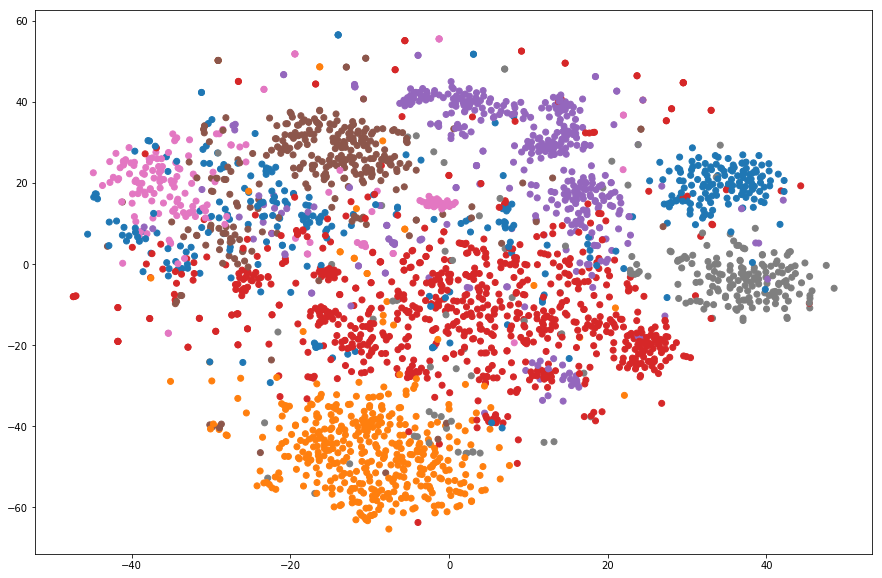

In [40]:
color_mapper = {0:'#1f77b4',1:'#7f7f7f',2:'#ff7f0e',3:'#d62728',4:'#9467bd',5:'#8c564b',6:'#e377c2'}
colors = [color_mapper[y[i]] for i in range(len(y))]

plt.figure(figsize=(15,10))
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=colors)
plt.show()